# Lead Time Capacity Minimisation

In this notebook I will showcase how it is possible to identify capacity for each team member that results in lowest lead time and least amount of idle time.  

This will be done by using multivariable linear regression.


### Data Load 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

def plot_learning_curves(model, X, y, test_size):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    return np.sqrt(train_errors), np.sqrt(val_errors)



In [2]:
capacity = pd.read_csv("capacity.csv")
capacity.drop(["Null"], axis=1, inplace=True)
capacity.dropna(inplace=True)
display(capacity.head())

,x1,x2,x3,x4,x5,x6,x7,y1,y2
0,0.57,0.51,0.31,2.04,2.11,2.61,0.01,83.7,98
1,0.38,0.31,0.35,4.48,1.35,4.79,0.06,109.9,72
2,1.25,1.35,0.10,4.88,4.82,1.64,0.12,447.9,253
3,1.22,0.60,0.12,2.34,1.16,0.37,0.13,95.4,113
4,0.93,0.95,0.66,2.95,4.49,2.96,0.13,43.8,49


In [3]:
capacity.dtypes

x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
y1    float64
y2      int64
dtype: object

In [4]:
capacity.describe()

,x1,x2,x3,x4,x5,x6,x7,y1,y2
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,0.668321,0.675136,0.340071,2.609671,2.482621,2.476136,0.067279,1273.211286,1055.460000
std,0.396890,0.396123,0.196789,1.451367,1.447139,1.430351,0.038257,13499.952768,10227.692182
min,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,23.300000,33.000000
25%,0.320000,0.327500,0.170000,1.370000,1.207500,1.247500,0.040000,89.075000,91.000000
50%,0.660000,0.670000,0.340000,2.730000,2.460000,2.470000,0.070000,180.600000,173.000000
75%,1.010000,1.010000,0.510000,3.860000,3.710000,3.670000,0.100000,452.100000,414.000000
max,1.350000,1.350000,0.680000,4.990000,5.000000,5.000000,0.140000,394382.300000,291934.000000


In [12]:
capacity[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']].corr()

,x1,x2,x3,x4,x5,x6,x7
x1,1.000000,0.001046,0.003229,-0.054511,-0.021760,-0.010340,-0.002613
x2,0.001046,1.000000,-0.010736,0.015651,0.014207,0.025400,0.057298
x3,0.003229,-0.010736,1.000000,-0.011246,0.038337,0.000111,0.028718
x4,-0.054511,0.015651,-0.011246,1.000000,0.049228,-0.023842,-0.000205
x5,-0.021760,0.014207,0.038337,0.049228,1.000000,0.061461,-0.000597
x6,-0.010340,0.025400,0.000111,-0.023842,0.061461,1.000000,-0.001278
x7,-0.002613,0.057298,0.028718,-0.000205,-0.000597,-0.001278,1.000000


array([[<AxesSubplot:title={'center':'y1'}>,
        <AxesSubplot:title={'center':'y2'}>]], dtype=object)

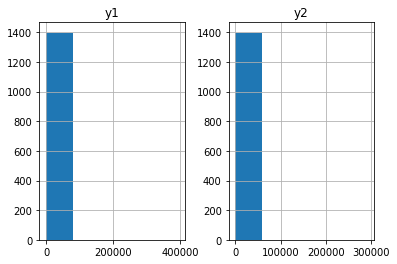

In [5]:
capacity[['y1', 'y2']].hist(bins=5)

<AxesSubplot:>

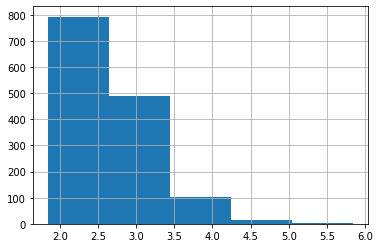

In [6]:
capacity['y'] = np.log10(capacity['y1'] + capacity['y2'])
capacity['y'].hist(bins=5)

In [7]:
X = capacity.values[:, 0:7]
y = capacity.values[:, 9]
print("X shape ", X.shape, " Y shape ", y.shape)

X shape  (1400, 7)  Y shape  (1400,)


In [8]:
min_index = np.argmin(y)
print("Capacity: ", X[min_index], " Score: ", y[min_index]**10)

Capacity:  [0.99 0.84 0.45 2.8  3.96 3.05 0.1 ]  Score:  469.6727429489358


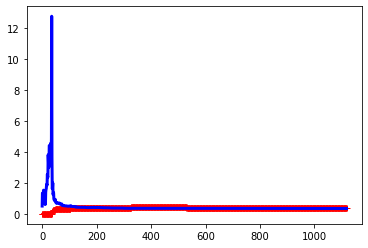

R^2: 0.49061968225640196
mean error: 0.37785205197168115


In [9]:
lin_reg = LinearRegression()
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
train_errors, val_errors = plot_learning_curves(lin_reg, X_poly, y, 0.20)
r_sq = lin_reg.score(X_poly, y)

plt.plot(train_errors, "r-+", linewidth=2, label="train")
plt.plot(val_errors, "b-", linewidth=3, label="val")
plt.show()

print("R^2:", r_sq)
print("mean error:", np.sqrt(mean_squared_error(lin_reg.predict(X_poly), y)))

In [10]:
minimum = minimize(lambda x : lin_reg.predict(poly_features.fit_transform([x])), np.array([0,0,0,0,0,0,0]))

print("Forecasted Capacity: ", np.around(minimum.x, 2), " Score: ", np.around(lin_reg.predict(poly_features.fit_transform([minimum.x]))**10, 0)[0])
print("Bruteforce Capacity: ", X[min_index], " Score: ",  np.around(y[min_index]**10))

Forecasted Capacity:  [0.98 0.92 0.52 3.37 3.24 3.94 0.1 ]  Score:  288.0
Bruteforce Capacity:  [0.99 0.84 0.45 2.8  3.96 3.05 0.1 ]  Score:  470.0
